In [1]:
import os
import shutil
os.chdir('/content')
if os.path.isdir('./hetvae'):
  shutil.rmtree('./hetvae/')
! git clone https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
import utils
import my_utils
import importlib
importlib.reload(my_utils)
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline


Cloning into 'hetvae'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 192 (delta 109), reused 86 (delta 34), pack-reused 0
Receiving objects: 100% (192/192), 18.96 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (109/109), done.
     |████████████████████████████████| 753.4 MB 6.9 kB/s 
     |████████████████████████████████| 4.0 MB 56.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext

In [ ]:
lc_files = glob('/content/hetvae/data/EDELSON/NGC4593_W2.dat')

In [ ]:
lc_files

['/content/hetvae/data/EDELSON/NGC4593_W2.dat']

In [ ]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/EDELSON/NGC4593_W2.dat')
lcs,max_len = my_utils.file_to_np(*(lc_files*100))
lcs = lcs[:64]

lcs, starts, max_len = zero_start(lcs)
lcs = my_utils.handle_dups(lcs)
union_tp = my_utils.union_timepoints(lcs)
print(len(union_tp))
lcs = my_utils.include_union_tp(lcs, max_len)
lcs.shape

#----------------------------------------------------------------------------------------------------------
# NORMALIZING
#----------------------------------------------------------------------------------------------------------

std_time = np.std(union_tp)
#std_flux = np.std(lcs[:,:,1].flatten())
#mean_flux = np.mean(lcs[:,:,1].flatten())
union_tp = union_tp / std_time
lcs[:,:,0] = lcs[:,:,0] / std_time

# normalize flux for light curves individually
for lc in lcs:
  lc[:,1] = lc[:,1] / np.std(lc[:,1])

# ----------------------------------------------------------------------------------------------------------
lcs = lcs.astype(np.float32)
union_tp = union_tp.astype(np.float32)
union_tp = torch.tensor(union_tp)
train_loader = torch.utils.data.DataLoader(lcs, batch_size=8)
dim = 1

print(f'lcs.shape=')

#-----------------------------------------------------------------------------------------------------------
#MASKS
#-----------------------------------------------------------------------------------------------------------

smask, rmask = my_utils.make_masks(lcs, batch_size=8)
print(f'smask[-1].shape=')
print(smask[0][0].sum(), rmask[0][0].sum())



dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of 

(64, 147, 3)


## Setting up arguments

In [ ]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [ ]:
args = Namespace(batch_size=8, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=256, enc_num_heads=3, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.000001, mixing='concat', mse_weight=0.0, n=256, net='hetvae', 
                 niters=1000, norm=False, normalize_input='znorm', num_ref_points=128, rec_hidden=128, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=1024)

In [ ]:
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **Generating Synthetic Data**

In [ ]:
# why is it subtracting 1 for the recon mask?
# dataset class that loads agn by folder you give it? agn object, agn.addLC('').addLC('')
# what is happening with the normalizations...
# kl negative? negative losses in general???
# make this capable of running on GPU
# fixing visualization
# adding error bars in the loss function?
# is my union_tp right? 
# different sequence sizes, some drastically shorter... how to make this not matter? does it? 


# do we subsample the light curve like they do...?
# i guess we do because you're just randomly selecting points each go round...





(8, 147)


## **Loading HeTVAE model**

In [ ]:
net = models.load_network(args, dim, union_tp) # dim = 1
params = list(net.parameters())
optimizer = optim.Adam(params, lr=.001)
# definitly want a decaying error rate...
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200], gamma=0.1)


## **Training**

In [ ]:
for epoch in range(1, 1500+1):#args.niters + 1):
      train_loss = 0
      train_n = 0
      avg_loglik, avg_kl, mse, mae = 0, 0, 0, 0
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          train_batch = train_batch.to(device)
          subsampled_mask = torch.tensor(smask[i][:, :, np.newaxis]).to(device) # should look like our flux values?
          recon_mask = torch.tensor(rmask[i][:, :,np.newaxis]).to(device)
          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              train_batch[:, :, 1:2] * subsampled_mask, subsampled_mask
          ), -1) 

    # #   def compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
          loss_info = net.compute_unsupervised_loss(
              train_batch[:, :, 0], # context_x, times
              context_y,             # context_y
              train_batch[:, :, 0], # target_x, same times? 
              torch.cat((            # flux values with only recon_mask values showing
                  train_batch[:, :, 1:2] * recon_mask, recon_mask
              ), -1),
              num_samples=args.k_iwae, # 1? 
              beta=1,       # ? 
          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len

      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
      if train_loss < 1:
        break
        # no test data yet
    #       for loader, num_samples in [(val_loader, 5), (test_loader, 100)]:
    #           utils.evaluate_hetvae(
    #               net,
    #               dim,
    #               loader,
    #               0.5,
    #               shuffle=False,
    #               k_iwae=num_samples,
    #               model_name=args.net,
    #           )

Iter: 100, train loss: 249.4434, avg nll: 246.2546, avg kl: 3.1888, mse: 5.268329, mae: 1.970248
Iter: 200, train loss: 51.0601, avg nll: 47.5148, avg kl: 3.5453, mse: 0.175257, mae: 0.335469
Iter: 300, train loss: 42.6952, avg nll: 37.3484, avg kl: 5.3467, mse: 0.148737, mae: 0.305965
Iter: 400, train loss: 44.1808, avg nll: 35.4906, avg kl: 8.6902, mse: 0.141896, mae: 0.299861
Iter: 500, train loss: 44.0563, avg nll: 34.9649, avg kl: 9.0915, mse: 0.145606, mae: 0.300167
Iter: 600, train loss: 33.5323, avg nll: 28.6103, avg kl: 4.9220, mse: 0.129444, mae: 0.284020
Iter: 700, train loss: 35.7716, avg nll: 30.4619, avg kl: 5.3097, mse: 0.136000, mae: 0.291994
Iter: 800, train loss: 34.9521, avg nll: 25.4469, avg kl: 9.5052, mse: 0.124252, mae: 0.279811
Iter: 900, train loss: 36.5412, avg nll: 24.5359, avg kl: 12.0053, mse: 0.121386, mae: 0.277111
Iter: 1000, train loss: 28.8918, avg nll: 23.2561, avg kl: 5.6357, mse: 0.114490, mae: 0.271940
Iter: 1100, train loss: 27.5715, avg nll: 22.7

## **Vizualization with increasing number of observations**

In [ ]:

def viz(test_loader, k_iwae=1, n_max=10, net):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    # don't keep track of gradients....
    with torch.no_grad():
        # how many points we show in the light curve? 
        for low in [10,30,50]:
            for i, batch in enumerate(test_loader):
                
                batch_len = batch.shape[0]
                batch = batch.to(device)
                #subsampled_mask = torch.zeros_like(batch[:, :, dim:2 * dim]).to(device)
                subsampled_mask = torch.tensor(smask[i][:, :, np.newaxis]).to(device)
                seqlen = batch.size(1)
                # for i in range(batch_len):
                  
                #     length = low
                #     obs_points = np.sort(np.random.choice(np.arange(seqlen), size=length, replace=False))
                #     subsampled_mask[i, obs_points, :] = 1
                #recon_mask = batch[:, :, dim:2 * dim] - subsampled_mask
                context_y = torch.cat((batch[:, :, 1:2] * subsampled_mask, subsampled_mask), -1)
                px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
                pred_mean.append(px.mean.cpu().numpy())
                pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
                targets.append((batch[:, :, 1:2]).cpu().numpy())
                masks.append(subsampled_mask.cpu().numpy())
                tp.append(batch[:, :, 0].cpu().numpy())
                if len(tp) % (n_max // 5) == 0:
                    break
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.850, axis=0)
    quantile1 = np.quantile(preds, 0.150, axis=0)
    print(preds.shape)
    print(preds)
    
    w = 2.0
    for index in range(n_max):
        plt.figure(figsize=(12.5, 1.5))
        for j in range(3):
            plt.subplot(1, 3, j + 1)
            plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
            #plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
            plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
            plt.xlim([0, 1])
            plt.xticks([])
            plt.yticks([])
            if j == 1 and index == 0:
                plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()


In [ ]:

# torch.cuda.empty_cache()
# pred_mean, pred_std = [],[]
# masks = []
# targets = []
# tp = []
# k_iwae = 10
# np.random.seed(0)
# with torch.no_grad():
#   batch = next(iter(train_loader)).to(device)
#   print(batch.shape)
#   batch_len = len(batch)
#   subsampled_mask = torch.tensor(smask[i][:, :, np.newaxis]).to(device)
#   seqlen = batch.size(1)
#   context_y = torch.cat((batch[:,:,1:2] * subsampled_mask, subsampled_mask), -1)
#   context_y = torch.cat((batch[:, :, :dim] * subsampled_mask, subsampled_mask), -1)
#   px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
#   pred = px.mean.cpu().numpy()
#   pred_std = torch.exp(0.5 * px.logvar).cpu().numpy() # e^(0.5 * logvar)

# points = batch.cpu().numpy()


torch.Size([8, 147, 3])


(15, 48, 147, 1) (15, 48, 147, 1) (48, 147, 1) (48, 147, 1) (48, 147)
(105, 48, 147, 1)
[[[[9.15767557]
   [8.66340195]
   [8.83038487]
   ...
   [6.4424315 ]
   [6.23277058]
   [5.99824852]]

  [[9.11814416]
   [8.22721138]
   [8.51527575]
   ...
   [5.89366212]
   [6.23235645]
   [5.792052  ]]

  [[8.65654029]
   [9.09668112]
   [8.70383886]
   ...
   [6.23419388]
   [6.11967457]
   [6.05448305]]

  ...

  [[8.71984369]
   [9.15237318]
   [8.9733206 ]
   ...
   [5.82757041]
   [5.78090658]
   [6.12511142]]

  [[8.9404245 ]
   [8.69030581]
   [8.33375478]
   ...
   [6.18587382]
   [6.0710346 ]
   [6.10570791]]

  [[8.8795527 ]
   [9.16966246]
   [8.97714933]
   ...
   [6.02207345]
   [5.79685966]
   [5.98357136]]]


 [[[8.54476742]
   [8.19967524]
   [8.63259936]
   ...
   [6.11008967]
   [6.31151536]
   [6.18463983]]

  [[8.4965237 ]
   [8.70714289]
   [9.00469345]
   ...
   [6.09457475]
   [6.19062233]
   [5.81736557]]

  [[9.87287579]
   [8.63093185]
   [9.30709855]
   ...
   [6.17

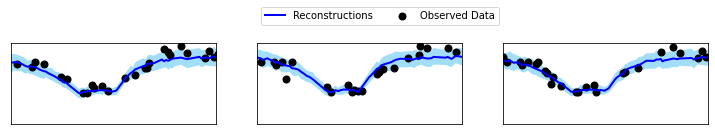

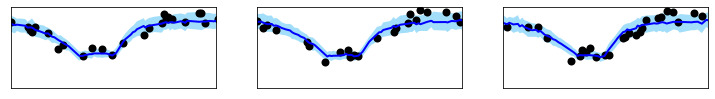

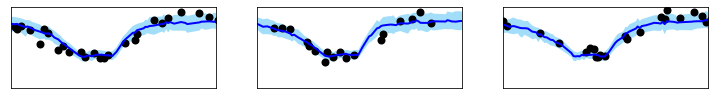

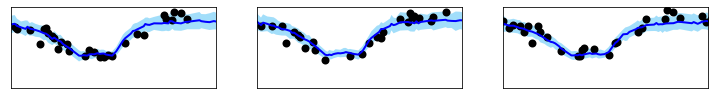

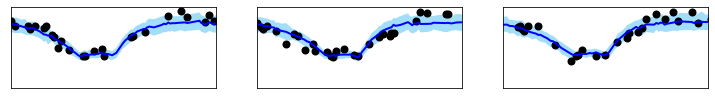

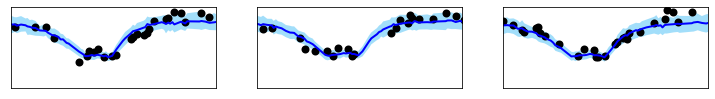

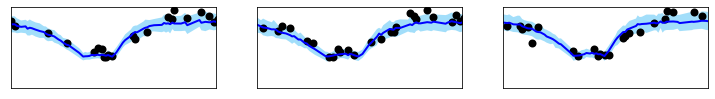

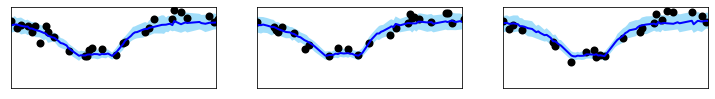

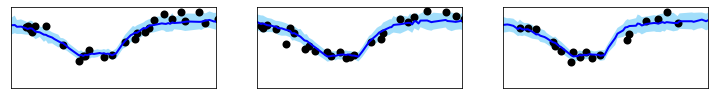

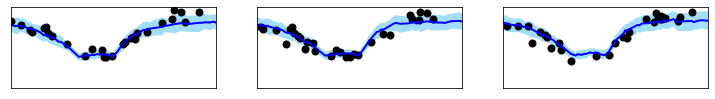

In [ ]:
viz(train_loader, k_iwae=15, net)